# Filling HUC12 / FIPS Codes

In [1]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

## Read in HUC12

In [2]:
# Get HUC12
layers = fiona.listlayers('./Data/huc12.gdb')
layers

['WBDHU12']

In [3]:
huc12 = gpd.read_file('./Data/huc12.gdb', layer = 'WBDHU12')

In [4]:
# converting to lat long
huc12.crs = {'init' :'epsg:2283'}

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
bay_states = ['NY', 'PA', 'VA', 'MD', 'WV', 'DE', 'DC']

In [6]:
keep = []
for i in bay_states:
    for x in huc12['STATES'].unique():
        if i in x:
            keep.append(x)
        else:
            pass

In [7]:
keephuc = huc12[huc12['STATES'].isin(keep)]

In [8]:
keephuc.shape

(5366, 20)

In [9]:
keephuc['STATES'].unique()

array(['DE', 'DE,MD', 'CN,NY', 'DE,MD,PA', 'DE,NJ', 'DE,PA',
       'CN,MI,OH,PA', 'CN,MI,NY,OH,PA', 'CT,NY', 'CT,NY,RI', 'MD',
       'MD,PA', 'KY,VA', 'MD,PA,WV', 'MD,VA', 'VA', 'MD,VA,WV', 'MD,WV',
       'MA,NY', 'NY,VT', 'MA,NY,VT', 'KY,OH,WV', 'KY,TN,VA', 'KY,VA,WV',
       'KY,WV', 'NC,VA', 'NC,TN,VA', 'NY', 'OH,PA', 'NJ,NY', 'OH,WV',
       'NJ,NY,PA', 'NJ,PA', 'DE,NJ,PA', 'NY,PA', 'PA', 'OH,PA,WV',
       'PA,WV', 'TN,VA', 'VA,WV', 'WV', 'CT,MA,NY', 'NY,RI', 'CN,NY,VT',
       'DC,MD,VA', 'DC,MD'], dtype=object)

In [10]:
keephuc.head(2)

,TNMID,METASOURCEID,SOURCEDATADESC,SOURCEORIGINATOR,SOURCEFEATUREID,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC12,NAME,HUTYPE,HUMOD,TOHUC,NONCONTRIBUTINGAREAACRES,NONCONTRIBUTINGAREASQKM,Shape_Length,Shape_Area,geometry
5497,{9C83472B-0B5D-48B8-9382-B6AAD67E37F2},None,None,None,None,2013-01-18T07:08:10,NaN,13348.68,54.02,DE,020402070401,Spring Branch-Murderkill River,S,DM,020402070404,0.0,0.0,0.441869,0.005616,"MULTIPOLYGON (((-75.52011 38.99948, -75.52001 ..."
5498,{47BB3A4D-1C14-46A2-926B-78F9891CDC8F},None,None,None,None,2013-01-18T07:08:10,NaN,12514.82,50.65,DE,020402070402,Browns Branch,S,DM,020402070404,0.0,0.0,0.502473,0.005262,"MULTIPOLYGON (((-75.48657 38.93200, -75.48697 ..."


## Read in County

In [11]:
# read in county boundaries
counties = gpd.read_file('./Data/tl_2017_us_county/tl_2017_us_county.shp')

In [12]:
# fips codes
fips = pd.read_csv('./Data/statefips.csv')

In [13]:
fips['fips'] = ['0' + str(i) if len(str(i)) == 1 else str(i) for i in fips['fips']]
fipsdict = dict(zip(fips['fips'], fips['abbr']))
counties['state'] = counties['STATEFP'].map(fipsdict)
counties['fullfips'] = counties['STATEFP'] + counties['COUNTYFP']

In [14]:
keep_counties = counties[counties['state'].isin(bay_states)]

In [15]:
keep_counties.shape

(345, 20)

## Read in Water & Benthic Data

In [16]:
water = pd.read_csv('./Data/Water_FINAL.csv', low_memory = False)

In [17]:
benthic = pd.read_csv('./Data/Benthic.csv', low_memory = False)

In [18]:
# getting geospatial point for each lat/lon
water['Point'] = [Point(x, y) for x, y in zip(water['Longitude'], water['Latitude'])]
benthic['Point'] = [Point(x, y) for x, y in zip(benthic['Longitude'], benthic['Latitude'])]

In [19]:
# get unique points
water_collections = water[['Longitude', 'Latitude']].drop_duplicates()
water_collections.shape

(2544, 2)

In [20]:
benthic_collections = benthic[['Longitude', 'Latitude']].drop_duplicates()
benthic_collections.shape

(5508, 2)

In [21]:
allpoints = pd.concat([water_collections,benthic_collections], axis = 0, sort = True)
allpoints.drop_duplicates(inplace = True)
allpoints.shape

(8040, 2)

In [22]:
allpoints['Point'] = [Point(x, y) for x, y in zip(allpoints['Longitude'], allpoints['Latitude'])]

## Get HUC12 

In [23]:
# get list of HUC12 for each point
hucs = []
names = []
for i in allpoints['Point']:
    
    huc = ""
    name = ""
    for x, y, z in zip(keephuc['NAME'], keephuc['HUC12'], keephuc['geometry']):
            
        if z.contains(i) == True:
            name = x
            huc = y
            break
        else:
            pass
            
    hucs.append(huc)
    names.append(name)
    
allpoints['HUC12'] = hucs
allpoints['HUCNAME'] = names

## Get FIPS codes

In [24]:
# get list of HUC12 for each point
fips = []
states = []
counties = []
for i in allpoints['Point']:
    
    fip = ""
    state = ""
    county = ""
    for w, x, y, z in zip(keep_counties['fullfips'], keep_counties['state'], keep_counties['NAMELSAD'], keep_counties['geometry']):
            
        if z.contains(i) == True:
            fip = w
            state = x
            county = y
            break
        else:
            pass
            
    fips.append(fip)
    states.append(state)
    counties.append(county)
    
allpoints['FIPS'] = fips
allpoints['STATE'] = states
allpoints['COUNTY'] = counties

In [25]:
allpoints = allpoints.dropna()

## Plots

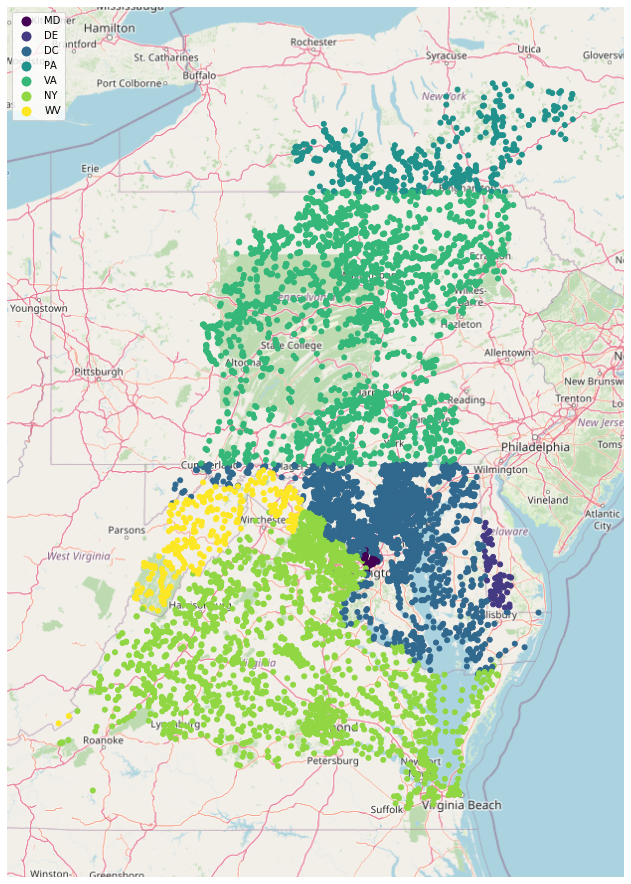

In [26]:
geometry = allpoints['Point']
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(allpoints[['STATE']], crs=crs, geometry=geometry)
ax = gplt.webmap(gdf, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf, hue= 'STATE', ax=ax, k = gdf['STATE'].nunique(), legend_labels = list(gdf['STATE'].unique()), legend = 'True')

### Map back to Dataframes

In [27]:
county_dict = dict(zip(allpoints['Point'].map(str), allpoints['COUNTY']))
state_dict = dict(zip(allpoints['Point'].map(str), allpoints['STATE']))
fips_dict = dict(zip(allpoints['Point'].map(str), allpoints['FIPS']))
huc_dict = dict(zip(allpoints['Point'].map(str), allpoints['HUC12']))
hucname_dict = dict(zip(allpoints['Point'].map(str), allpoints['HUCNAME']))

In [28]:
# mapping water values
water['HUC12_'] = water['Point'].map(str).map(huc_dict)
water['HUCNAME_'] = water['Point'].map(str).map(hucname_dict)
water['FIPS_'] = water['Point'].map(str).map(fips_dict)
water['COUNTY_'] = water['Point'].map(str).map(county_dict)
water['STATE_'] = water['Point'].map(str).map(state_dict)

In [29]:
# mapping benthic values
benthic['HUC12_'] = benthic['Point'].map(str).map(huc_dict)
benthic['HUCNAME_'] = benthic['Point'].map(str).map(hucname_dict)
benthic['FIPS_'] = benthic['Point'].map(str).map(fips_dict)
benthic['COUNTY_'] = benthic['Point'].map(str).map(county_dict)
benthic['STATE_'] = benthic['Point'].map(str).map(state_dict)

#  to csv

In [30]:
water.dropna(subset = ['Latitude', 'Longitude'], inplace = True)
benthic.dropna(subset = ['Latitude', 'Longitude'], inplace = True)

water.to_csv('./Data/Water_FINAL.csv')
benthic.to_csv('./Data/Benthic_FINAL.csv')

## Plotting Maps

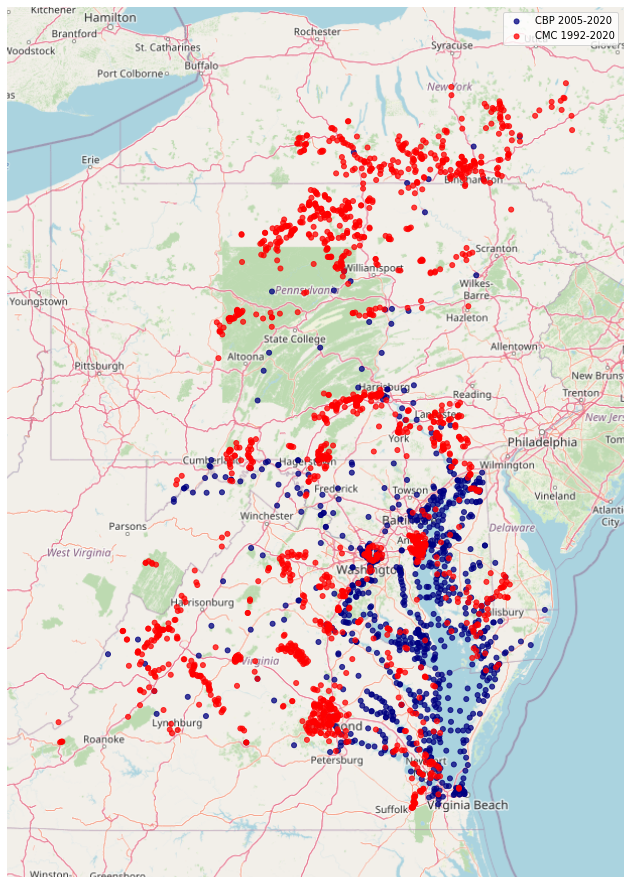

In [31]:
# plotting water
water_cbp = water[water['Database']=='CBP'].drop_duplicates(subset = ['Latitude', 'Longitude'])
water_cmc = water[water['Database']=='CMC'].drop_duplicates(subset = ['Latitude', 'Longitude'])

geometry1 = water_cbp['Point']
geometry2 = water_cmc['Point']
crs = {'init': 'epsg:4326'}
gdf1 = gpd.GeoDataFrame(water_cbp[['Database']], crs=crs, geometry=geometry1)
gdf2 = gpd.GeoDataFrame(water_cmc[['Database']], crs=crs, geometry=geometry2)

ax = gplt.webmap(gdf2, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf1, color = 'navy', ax=ax, alpha = 0.75, label = 'CBP 2005-2020')
gplt.pointplot(gdf2, color = 'red', ax=ax, alpha = 0.75, label = 'CMC 1992-2020')
plt.legend()

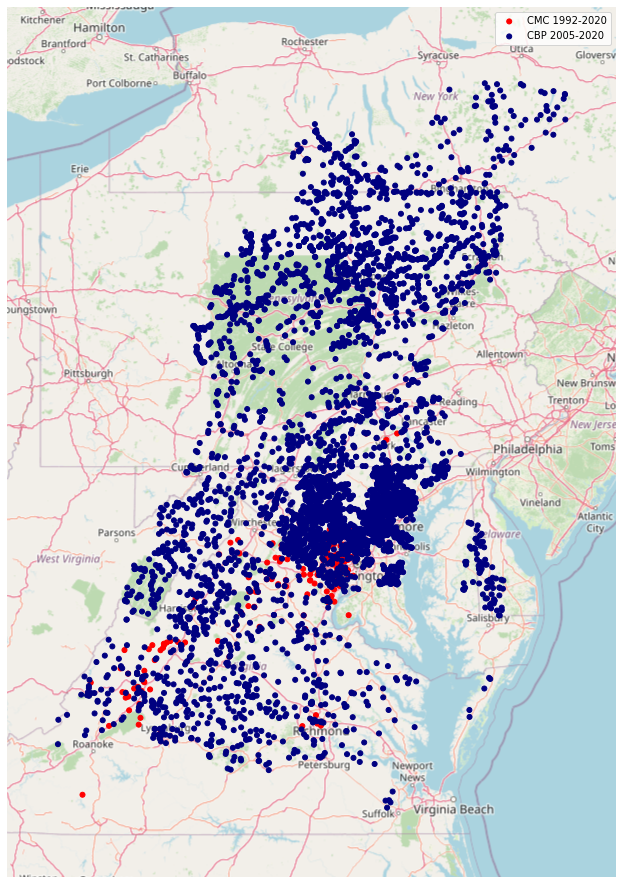

In [33]:
# plotting benthic
benthic_cbp = benthic[benthic['Database']=='CBP'].drop_duplicates(subset = ['Latitude', 'Longitude'])
benthic_cmc = benthic[benthic['Database']=='CMC'].drop_duplicates(subset = ['Latitude', 'Longitude'])

benthic_cbp = benthic_cbp.dropna(subset = ['Latitude', 'Longitude'])

geometry1 = benthic_cbp['Point']
geometry2 = benthic_cmc['Point']
crs = {'init': 'epsg:4326'}
gdf1 = gpd.GeoDataFrame(benthic_cbp[['Database']], crs=crs, geometry=geometry1)
gdf2 = gpd.GeoDataFrame(benthic_cmc[['Database']], crs=crs, geometry=geometry2)

ax = gplt.webmap(gdf1, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf2, color = 'red', ax=ax, label = 'CMC 1992-2020')
gplt.pointplot(gdf1, color = 'navy', ax=ax, label = 'CBP 2005-2020')

plt.legend()